<a href="https://colab.research.google.com/github/sarvan0506/AI/blob/Dev/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Image Augumentation using Cut-out and Implementing GradCAM to analyze the effect of Cut-out.

#### Loading necessary Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2

#### Loading Dataset from Keras library

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

#### Print some random images

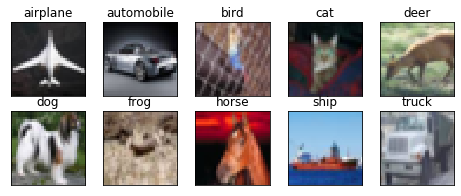

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#### A utility function to plot model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#### A Utility function to calculate accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### convert class labels to binary class labels

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Pick any 6 images from the test dataset for inspection

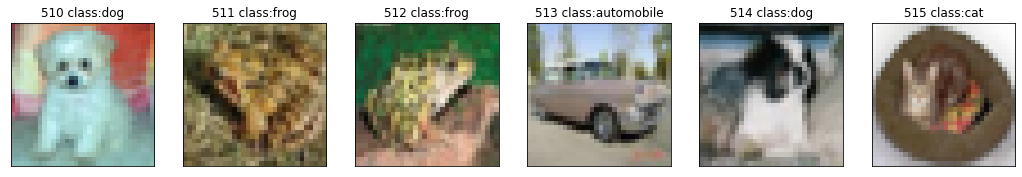

In [0]:
img_no = 6
rand_id = 510

fig = plt.figure(figsize=(18,3))
for i in range(img_no):
  ax = fig.add_subplot(1, 6, 1 + i, xticks=[], yticks=[])
  ax.set_title(str(rand_id + i) + " class:" + class_names[np.argmax(test_labels[rand_id + i])])
  plt.imshow(test_features[rand_id + i])
plt.show()


In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 16
#model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 8
#model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 4
#model.add(Dropout(0.5))

model.add(Convolution2D(4, 1))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(10, 4))
model.add(Flatten())


model.add(Activation('softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_34 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=20)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
390/390 [==============================] - 38s 97ms/step - loss: 1.3449 - acc: 0.5335 - val_loss: 1.2369 - val_acc: 0.5874
Epoch 2/20
390/390 [==============================] - 29s 75ms/step - loss: 0.8807 - acc: 0.7097 - val_loss: 1.1807 - val_acc: 0.6263
Epoch 3/20
390/390 [==============================] - 29s 75ms/step - loss: 0.7141 - acc: 0.7736 - val_loss: 0.8108 - val_acc: 0.7417
Epoch 4/20
390/390 [==============================] - 29s 75ms/step - loss: 0.6067 - acc: 0.8125 - val_loss: 1.0230 - val_acc: 0.6975
Epoch 5/20
390/390 [==============================] - 29s 75ms/step - loss: 0.5232 - acc: 0.8474 - val_loss: 0.8260 - val_acc: 0.7584
Epoch 6/20
390/390 [==============================] - 29s 75ms/step - loss: 0.4522 - acc: 0.8740 - val_loss: 0.9002 - val_acc: 0.7483
Epoch 7/20
390/390 [==============================] - 29s 75ms/step - loss: 0.3950 - acc: 0.8986 - val_loss: 0.8687 - val_acc: 0.7640
Epoch 8/20
390/390 [==============================] - 29s 75ms

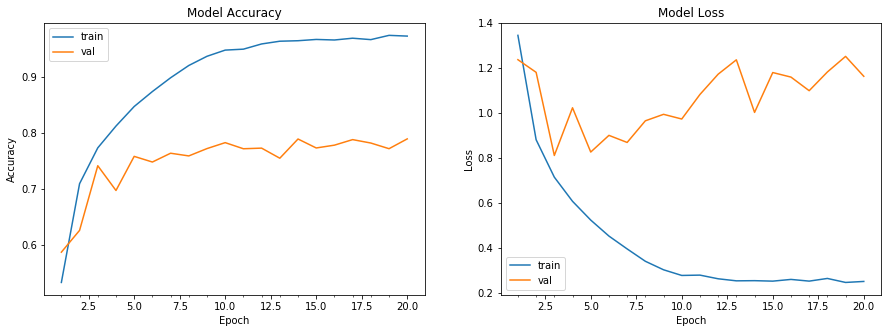

Accuracy on test data is: 78.96


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False) # for normalization


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#Function to generate original image and GradCAM image
def getGradCam(image_number, layer, model):
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  
  # Pixel normalization for test images
  test_features = test_features.astype('float32')/255

  # convert class labels to binary class labels
  test_labels = np_utils.to_categorical(test_labels, num_classes)
  
  img = test_features[image_number]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(96):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
 
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  
  img = test_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 - (255 * heatmap))
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

  return heatmap, superimposed_img, class_idx

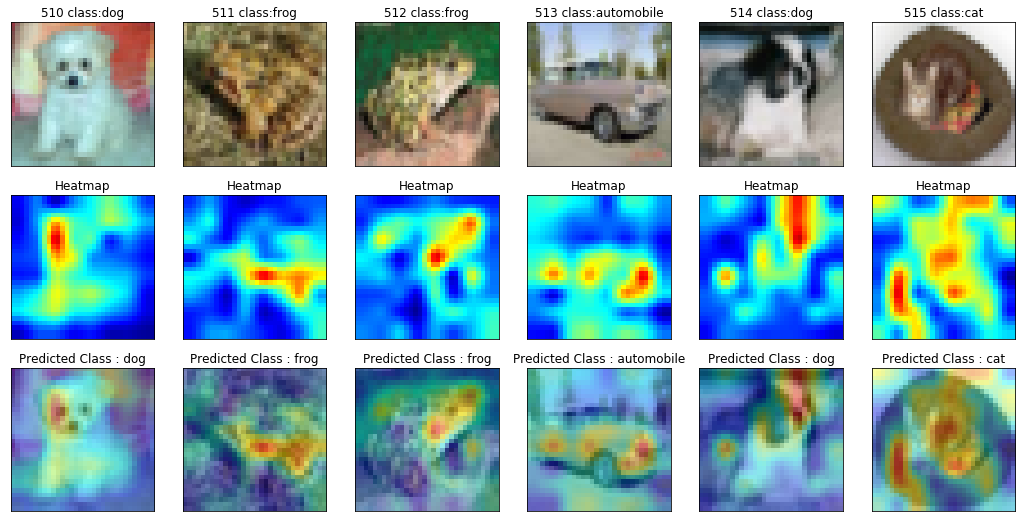

In [0]:
p = 0
img_no = 6
rand_id = 510

fig = plt.figure(figsize=(18,9))
for i in range(img_no):
  n = rand_id + i
  h, s, c = getGradCam(n, "activation_29", model)
  p = i + 1
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title(str(rand_id + i) + " class:" + class_names[np.argmax(test_labels[rand_id + i])])
  plt.imshow(test_features[rand_id + i])
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Heatmap")
  plt.imshow(h)
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Predicted Class : " + class_names[c])
  plt.imshow(s)
plt.show()

#### With usage of GradCAM we are able to see where the DNN is looking in order to predict a particular class. The red spot in the above mentioned images are the high activation area. But the problem here is that the Network does not look an entire image to predict a class for example in the 1st image the region around the dog's eye got high activation and the network only focussed on that particular area. The problem with this network is that if an image of the same dog turned around is fed, most likely the network not going to perform well hence it could not see the dog's eye. To overcome this problem we introduce cut-out an image augumentation technique which randomly erase a portion of an image and form new image. This will help in not only increase in the size of the dataset but also provides excellent generalization properties to the network trained.

In [0]:
!wget https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py

from random_eraser import get_random_eraser   # to implement cut-out

--2019-12-05 19:47:01--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py’

random_eraser.py    100%[===================>]     888  --.-KB/s    in 0s      

2019-12-05 19:47:01 (204 MB/s) - ‘random_eraser.py’ saved [888/888]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=20)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
390/390 [==============================] - 37s 95ms/step - loss: 1.4609 - acc: 0.4938 - val_loss: 1.1649 - val_acc: 0.6034
Epoch 2/20
390/390 [==============================] - 29s 73ms/step - loss: 1.0199 - acc: 0.6552 - val_loss: 0.9369 - val_acc: 0.6884
Epoch 3/20
390/390 [==============================] - 29s 73ms/step - loss: 0.8714 - acc: 0.7137 - val_loss: 0.8619 - val_acc: 0.7238
Epoch 4/20
390/390 [==============================] - 28s 73ms/step - loss: 0.7706 - acc: 0.7514 - val_loss: 0.8053 - val_acc: 0.7440
Epoch 5/20
390/390 [==============================] - 29s 73ms/step - loss: 0.7073 - acc: 0.7778 - val_loss: 0.8456 - val_acc: 0.7419
Epoch 6/20
390/390 [==============================] - 29s 73ms/step - loss: 0.6553 - acc: 0.7989 - val_loss: 0.7899 - val_acc: 0.7597
Epoch 7/20
390/390 [==============================] - 29s 73ms/step - loss: 0.6119 - acc: 0.8167 - val_loss: 0.8125 - val_acc: 0.7664
Epoch 8/20
390/390 [==============================] - 29s 73ms

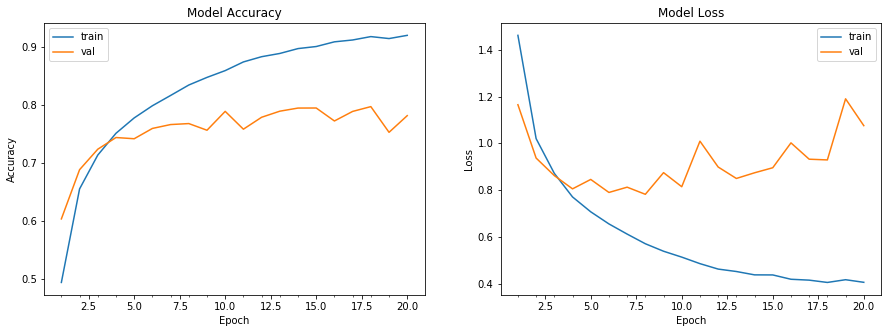

Accuracy on test data is: 78.18


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Now the model is trained with cut-out, lets see the impact it has on the activation maps

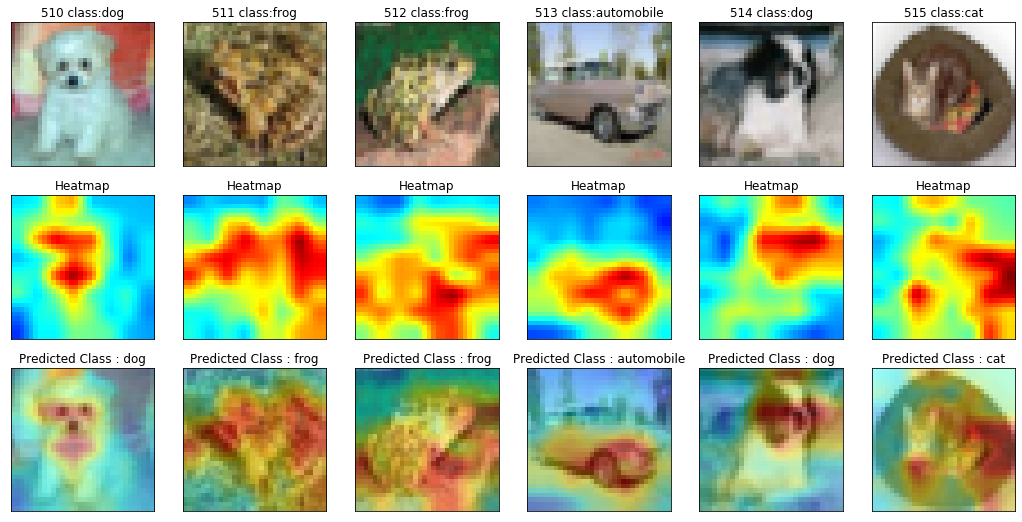

In [0]:
p = 0
img_no = 6
rand_id = 510

fig = plt.figure(figsize=(18,9))
for i in range(img_no):
  n = rand_id + i
  h, s, c = getGradCam(n, "activation_38", model)
  p = i + 1
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title(str(rand_id + i) + " class:" + class_names[np.argmax(test_labels[rand_id + i])])
  plt.imshow(test_features[rand_id + i])
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Heatmap")
  plt.imshow(h)
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Predicted Class : " + class_names[c])
  plt.imshow(s)
plt.show()

#### From the activation maps above we can clearly see that the network is looking into much broader area than before to predict a class. We could see the activation spread evenly across an image rather piling up on a narrow region. Hence the impact of cut-out is understood and the implementation of GradCAM is done.